In [1]:
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
import matplotlib.pyplot as plt

In [2]:
#!pip install gym

In [32]:
# GridWorld adında bir ortam oluşturuyoruz.
# Bu ortamda ajan belirli bir hedefe ulaşmaya çalışacak.
class GridWorldEnv(gym.Env):
    def __init__(self, size=20):
        super(GridWorldEnv, self).__init__()
        self.size = size  # Grid'in boyutu 
        self.action_space = gym.spaces.Discrete(4)  # 4 hareket: yukarı, aşağı, sola, sağa
        self.observation_space = gym.spaces.Box(low=0, high=size, shape=(2,), dtype=np.int32) # Ajanın konumu (x, y)

    # Ortamı başlat (ajan ve hedef konumlarını rastgele belirle)
    def reset(self):
        self.agent_pos = [np.random.randint(1, self.size - 1), np.random.randint(1, self.size - 1)]
        
        # Hedefi rastgele seç, ancak ajanın başlangıç konumundan farklı olmalı
        while True:
            self.goal_pos = [np.random.randint(1, self.size - 1), np.random.randint(1, self.size - 1)]
            if self.goal_pos != self.agent_pos:
                break
        
        # Ajan ve hedefin konumunu döndür
        return np.array(self.agent_pos + self.goal_pos)

    # Ortamda bir adım (action) gerçekleştir
    def step(self, action):
        if action == 0:
            self.agent_pos[0] = max(0, self.agent_pos[0] - 1)  # Yukarı
        elif action == 1:
            self.agent_pos[0] = min(self.size - 1, self.agent_pos[0] + 1)  # Aşağı
        elif action == 2:
            self.agent_pos[1] = max(0, self.agent_pos[1] - 1)  # Sola
        elif action == 3:
            self.agent_pos[1] = min(self.size - 1, self.agent_pos[1] + 1)  # Sağa

        # Hedefe ulaşıldı mı kontrol et
        done = self.agent_pos == self.goal_pos
        # Hedefe ulaşıldıysa ödül ver, ulaşılmadıysa cezalandır
        reward = 1 if done else -0.1
        # Yeni durumu (ajan ve hedef konumları) döndür
        return np.array(self.agent_pos + self.goal_pos), reward, done, {}

    # Ortamı görselleştir
    def render(self, mode='human'):
        grid = np.zeros((self.size, self.size), dtype=str)
        grid[:] = '-'
        grid[tuple(self.agent_pos)] = 'A'  # Ajanın konumu 'A' ile işaretleniyor
        grid[tuple(self.goal_pos)] = 'G'  # Hedefin konumu 'G' ile işaretleniyor
        print('\n'.join(' '.join(row) for row in grid))
        print()
        
    # Ajan ve hedefin konumlarını manuel olarak belirle    
    def set_state(self, agent_pos, goal_pos):
        self.agent_pos = agent_pos
        self.goal_pos = goal_pos
        
    # Ajan ve hedefin mevcut konumlarını döndür    
    def get_state(self):
        return np.array(self.agent_pos + self.goal_pos)


In [4]:
# Derin Q-Ağlarını (DQN) tanımlayan model sınıfı
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        # Modelin katmanlarını tanımla (3 katmanlı tam bağlantılı ağ)
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 24),  # Giriş katmanı (4 boyutlu girdiler)
            nn.ReLU(), # Aktivasyon fonksiyonu
            nn.Linear(24, 24), # Orta katman
            nn.ReLU(),
            nn.Linear(24, output_dim) # Çıkış katmanı (4 hareket)
        )
     
    # İleri doğru hesaplama (verilen durum için Q değerlerini döndür) 
    def forward(self, x):
        return self.fc(x)

# Traning Phase

In [5]:
# DQN modelini eğiten fonksiyon
def train(env, model, episodes, learning_rate=0.001, gamma=0.99):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate) # Optimizasyon fonksiyonu
    criterion = nn.MSELoss() # Kayıp fonksiyonu (MSE)
    memory = deque(maxlen=10000) # Deneyim havuzu
    batch_size = 64 # Batch boyutu
    epsilon = 1.0 # Başlangıç keşif oranı
    epsilon_decay = 0.995 # Keşif oranı azalımı
    epsilon_min = 0.01 # Minimum keşif oranı
    episode_losses = []  # Episode loss(kayıp) değerlerini saklamak için

    # Belirtilen sayıda bölüm boyunca eğit
    for episode in range(episodes):
        state = env.reset() # Ortamı sıfırla ve başlangıç durumunu al
        state = torch.tensor(state, dtype=torch.float32) # Durumu tensöre çevir
        done = False
        loss = None  # Her döngü başında loss'u None olarak başlat
        episode_loss = 0.0  # Her episode için toplam loss

        while not done:
            # Rastgele hareket seç veya modelin öngördüğü en iyi hareketi seç
            if random.random() < epsilon:
                action = env.action_space.sample() # Rastgele hareket
            else:
                q_values = model(state) # Modelden Q değerlerini al
                action = torch.argmax(q_values).item()  # En yüksek Q değerine sahip hareketi seç
            
            # Hareketi ortamda uygula
            next_state, reward, done, _ = env.step(action)
            next_state = torch.tensor(next_state, dtype=torch.float32)
            
            # Deneyimi deneyim havuzuna ekle
            memory.append((state, action, reward, next_state, done))
            state = next_state

            # Deneyim havuzu yeterli boyuta ulaşmışsa minibatch ile eğitim yap
            if len(memory) > batch_size:
                batch = random.sample(memory, batch_size) # Deneyim havuzundan rastgele bir batch al
                states, actions, rewards, next_states, dones = zip(*batch)

                states = torch.stack(states)
                next_states = torch.stack(next_states)
                actions = torch.tensor(actions)
                rewards = torch.tensor(rewards)
                dones = torch.tensor(dones, dtype=torch.float32)
                  
                # Q değerlerini hesapla  
                q_values = model(states).gather(1, actions.unsqueeze(1)).squeeze(1)
                max_next_q_values = model(next_states).detach().max(1)[0]
                expected_q_values = rewards + gamma * max_next_q_values * (1 - dones)

                # Kayıp fonksiyonunu hesapla ve modeli güncelle
                loss = criterion(q_values, expected_q_values)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                episode_loss += loss.item()

            # Keşif oranını azalt
            if epsilon > epsilon_min:
                epsilon *= epsilon_decay

        episode_losses.append(episode_loss)  # Her episode sonunda toplam loss'u ekle
        print(f"Episode {episode + 1}/{episodes}, Loss: {episode_loss:.4f}, Epsilon: {epsilon:.2f}")

    print("Eğitim tamamlandı")
    return episode_losses  # Loss listesini dön

In [6]:
# Modeli ve ortamı oluşturma
env = GridWorldEnv()
model = DQN(env.observation_space.shape[0] * 2, env.action_space.n)  # input_dim şimdi 4 olacak

episode_losses = train(env, model, 300)  # 300 bölüm için eğitim

Episode 1/300, Loss: 0.0000, Epsilon: 0.89
Episode 2/300, Loss: 6.2535, Epsilon: 0.30
Episode 3/300, Loss: 14.2219, Epsilon: 0.01
Episode 4/300, Loss: 20.0409, Epsilon: 0.01
Episode 5/300, Loss: 16.4550, Epsilon: 0.01
Episode 6/300, Loss: 13.2837, Epsilon: 0.01
Episode 7/300, Loss: 8.0680, Epsilon: 0.01
Episode 8/300, Loss: 58.3627, Epsilon: 0.01
Episode 9/300, Loss: 45.2457, Epsilon: 0.01
Episode 10/300, Loss: 5.0546, Epsilon: 0.01
Episode 11/300, Loss: 12.0010, Epsilon: 0.01
Episode 12/300, Loss: 18.4868, Epsilon: 0.01
Episode 13/300, Loss: 19.1348, Epsilon: 0.01
Episode 14/300, Loss: 1.8865, Epsilon: 0.01
Episode 15/300, Loss: 21.3175, Epsilon: 0.01
Episode 16/300, Loss: 0.0108, Epsilon: 0.01
Episode 17/300, Loss: 1.3683, Epsilon: 0.01
Episode 18/300, Loss: 0.8593, Epsilon: 0.01
Episode 19/300, Loss: 2.9990, Epsilon: 0.01
Episode 20/300, Loss: 7.4053, Epsilon: 0.01
Episode 21/300, Loss: 15.5746, Epsilon: 0.01
Episode 22/300, Loss: 11.4035, Epsilon: 0.01
Episode 23/300, Loss: 7.1844,

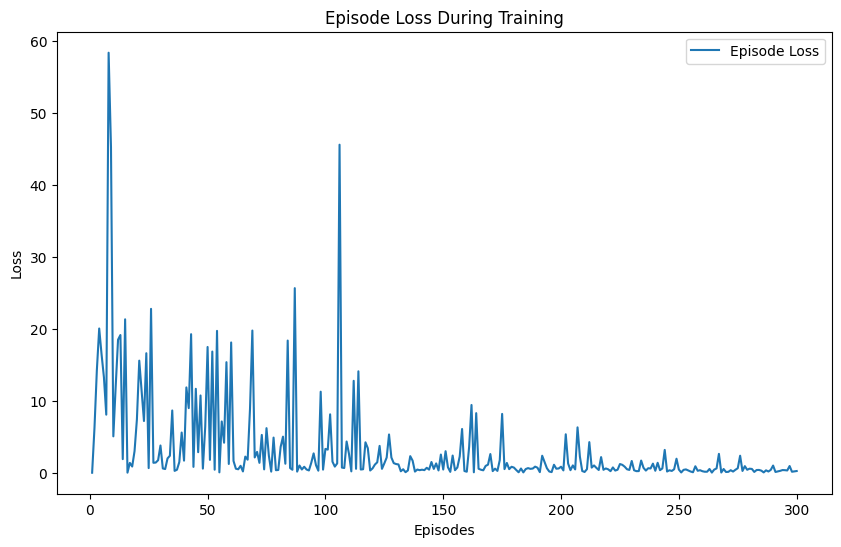

In [7]:
# Loss grafiğini çiz
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(episode_losses) + 1), episode_losses, label='Episode Loss')
plt.xlabel('Episodes')
plt.ylabel('Loss')
plt.title('Episode Loss During Training')
plt.legend()
plt.show()

# Test Phase

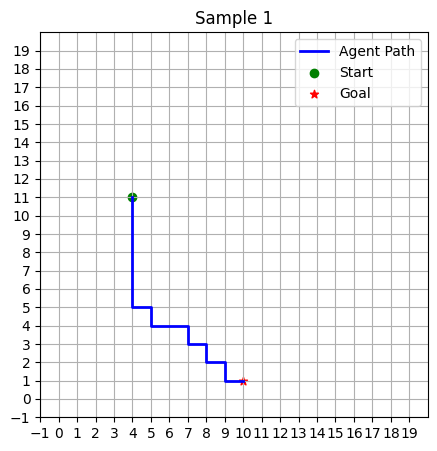

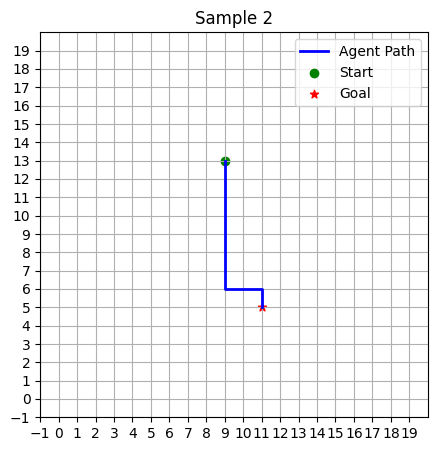

In [31]:
# Eğitilen ajanı test eden fonksiyon
def test_agent(env, model, sample_size):
    for sample in range(sample_size):
        state = env.reset() # Ortamı sıfırla
        state = torch.tensor(state, dtype=torch.float32)
        done = False

        start_pos = env.agent_pos.copy()  # Başlangıç pozisyonunu sakla
        agent_path = [start_pos]  # Ajanın yolunu saklamak için liste

        while not done:
            q_values = model(state)
            action = torch.argmax(q_values).item()

            next_state, _, done, _ = env.step(action)
            state = torch.tensor(next_state, dtype=torch.float32)
            agent_path.append(env.agent_pos.copy())  # Ajanın her adımdaki konumunu ekle

        # Yolu çiz
        plt.figure(figsize=(5, 5))
        plt.title(f"Sample {sample + 1}")

        # Ajanın yolu
        x, y = zip(*agent_path)
        plt.plot(y, x, color='blue', linewidth=2, label='Agent Path')

        # Başlangıç ve hedef noktaları
        plt.scatter(start_pos[1], start_pos[0], c='green', marker='o', label='Start')
        plt.scatter(env.goal_pos[1], env.goal_pos[0], c='red', marker='*', label='Goal')

        # Grafik ayarları
        plt.xlim(-1, env.size)  # X eksenini genişlet
        plt.ylim(-1, env.size)  # Y eksenini genişlet
        plt.xticks(range(-1, env.size))
        plt.yticks(range(-1, env.size))
        plt.grid(True)
        plt.gca()#.invert_yaxis()  # Y eksenini ters çevir
        plt.legend()
        plt.show()

# Eğitimden sonra ajanı test et
test_agent(env, model, 2)  # 1 test bölümü

# Model Save

In [39]:
torch.save(model.state_dict(), './models/best_model.pth')

# Custom Test

In [34]:
def custom_test(env, model, agent_pos, goal_pos):
    env.set_state(agent_pos.copy(), goal_pos)
    #env.reset()  # Özel durum ile ortamı başlat
    state = torch.tensor(env.get_state(), dtype=torch.float32)
    done = False
    total_reward = 0
    agent_path = [agent_pos.copy()]  # Ajanın yolunu saklamak için liste

    while not done:
        q_values = model(state)
        action = torch.argmax(q_values).item()

        next_state, reward, done, _ = env.step(action)
        state = torch.tensor(next_state, dtype=torch.float32)
        total_reward += reward
        agent_path.append(env.agent_pos.copy())  # Ajanın her adımdaki konumunu ekle

    # Yolu çiz
    plt.figure(figsize=(5, 5))
    plt.title(f"Ajanın Yolu (Başlangıç: {agent_pos}, Hedef: {goal_pos})")

    # Ajanın yolu
    x, y = zip(*agent_path)
    plt.plot(y, x, color='blue', linewidth=2, label='Agent Path')

    # Başlangıç ve hedef noktaları
    plt.scatter(agent_pos[1], agent_pos[0], c='green', marker='o', label='Start')
    plt.scatter(goal_pos[1], goal_pos[0], c='red', marker='*', label='Goal')

    # Grafik ayarları
    plt.xlim(-1, env.size)  # X eksenini genişlet
    plt.ylim(-1, env.size)  # Y eksenini genişlet
    plt.xticks(range(-1, env.size))
    plt.yticks(range(-1, env.size))
    plt.grid(True)
    plt.gca()#.invert_yaxis()  # Y eksenini ters çevir
    plt.legend()
    plt.show()

    return total_reward, agent_path

In [35]:
def generate_random_pos(size):    
    agent_pos = [np.random.randint(1, size - 1), np.random.randint(1, size - 1)]
        
    # Hedefi rastgele seç, ancak ajanın başlangıç konumundan farklı olmalı
    while True:
        goal_pos = [np.random.randint(1, size - 1), np.random.randint(1, size - 1)]
        if goal_pos != agent_pos:
            break
    return agent_pos,goal_pos

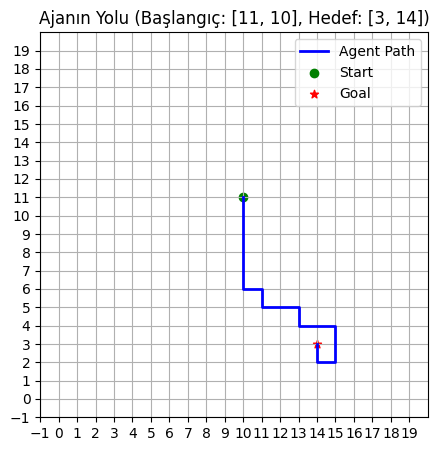

[11, 10] [3, 14]
Toplam Ödül: -0.5000000000000002
Kahramanın yolu: [[11, 10], [10, 10], [9, 10], [8, 10], [7, 10], [6, 10], [6, 11], [5, 11], [5, 12], [5, 13], [4, 13], [4, 14], [4, 15], [3, 15], [2, 15], [2, 14], [3, 14]]


In [38]:
# Özel durum için testi çalıştır ve görselleştir
#custom_agent_pos = [3, 5]
#custom_goal_pos = [17, 17]

custom_agent_pos, custom_goal_pos = generate_random_pos(env.size)
total_reward, agent_path = custom_test(env, model, custom_agent_pos, custom_goal_pos)

print(custom_agent_pos,custom_goal_pos)
print(f"Toplam Ödül: {total_reward}")
print(f"Kahramanın yolu: {agent_path}")

In [ ]:
"""
Batch size:
Reward 
Memory bellek alanı 
Harita boyutu
episode 
"""